In [1]:
#default_exp srcnn

# SRCNN: Image super-resolution using deep convolutional networks

https://arxiv.org/abs/1501.00092

31 Dec 2014

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
#import PIL
#from pathlib import PosixPath

In [4]:
#export
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [6]:
import sys
sys.path.append('..')
from superres.datasets import *
from superres.databunch import *

In [7]:
seed = 8610
random.seed(seed)
np.random.seed(seed)

## Model

In [8]:
#export
class SRCNN(nn.Module):
    """ Image super-resolution using deep convolutional networks """

    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=3, kernel_size=5, padding=2)
        self.activate = nn.ReLU()

    def forward(self, x):
        h = self.activate(self.conv1(x))
        h = self.activate(self.conv2(h))
        return self.conv3(h)

## DataBunch

In [9]:
train_hr = div2k_train_hr_crop_256

In [10]:
in_size = 256
out_size = 256
scale = 4
bs = 10

ImageDataBunch;

Train: LabelList (25245 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /home/jovyan/notebook/datasets/DIV2K/DIV2K_train_HR_crop/256;

Valid: LabelList (6311 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /home/jovyan/notebook/datasets/DIV2K/DIV2K_train_HR_crop/256;

Test: None


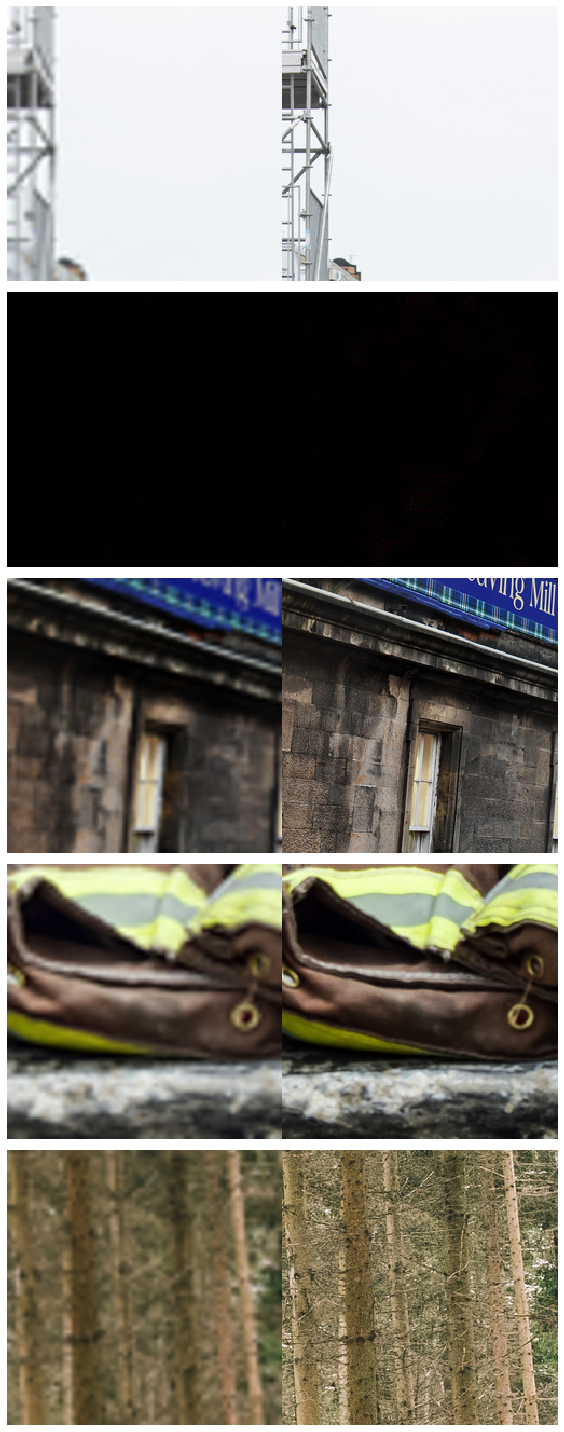

In [11]:
data = create_sr_databunch(train_hr, in_size=in_size, out_size=out_size, scale=scale, bs=bs, seed=seed)
print(data)
data.show_batch()

## Training

In [12]:
model = SRCNN()
loss_func = MSELossFlat()
metrics = [m_psnr, m_ssim]
learn = Learner(data, model, loss_func=loss_func, metrics=metrics)
model_name = model.__class__.__name__

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07
Min loss divided by 10: 1.58E-03


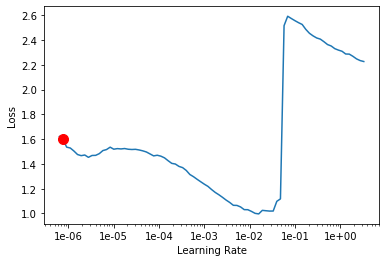

In [13]:
lr_find(learn)
learn.recorder.plot(suggestion=True)

In [14]:
lr = 1e-3
lrs = slice(lr)
epoch = 3
pct_start = 0.3
wd = 1e-3
save_fname = model_name

In [15]:
callbacks = [ShowGraph(learn), SaveModelCallback(learn, name=save_fname)]

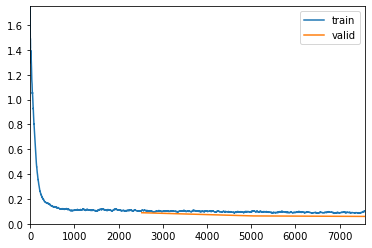

Better model found at epoch 0 with valid_loss value: 0.08927701413631439.
Better model found at epoch 1 with valid_loss value: 0.06340917944908142.
Better model found at epoch 2 with valid_loss value: 0.059471651911735535.


In [16]:
learn.fit_one_cycle(epoch, lrs, pct_start=pct_start, wd=wd, callbacks=callbacks)

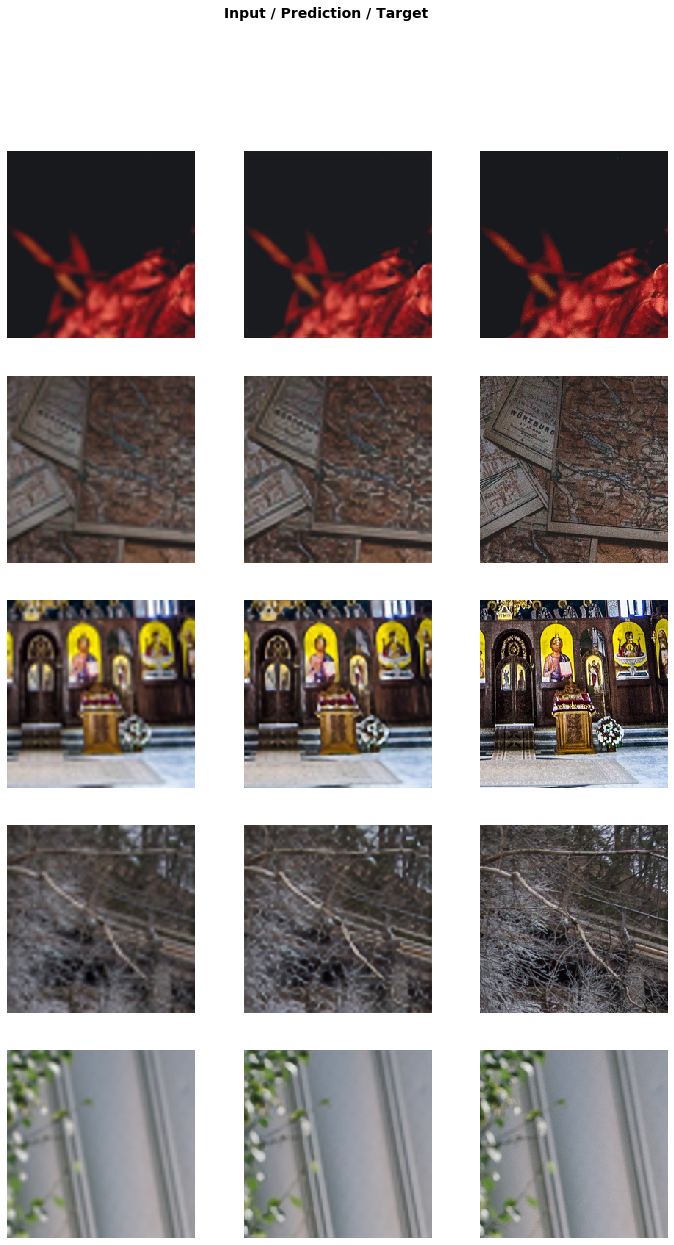

In [17]:
learn.show_results()

## Test

In [18]:
test_hr = set14_hr

In [19]:
il_test_x = ImageImageList.from_folder(test_hr, after_open=partial(after_open_image, size=in_size, scale=4, sizeup=True))
il_test_y = ImageImageList.from_folder(test_hr, after_open=partial(after_open_image, size=out_size))

In [20]:
learn.load(save_fname)

Learner(data=ImageDataBunch;

Train: LabelList (25245 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /home/jovyan/notebook/datasets/DIV2K/DIV2K_train_HR_crop/256;

Valid: LabelList (6311 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /home/jovyan/notebook/datasets/DIV2K/DIV2K_train_HR_crop/256;

Test: None, model=SRCNN(
  (conv1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (activate): ReLU()
), opt_func=functools.partial(<class 'to

bicubic: PSNR:24.11,SSIM:0.7822
SRCNN:	 PSNR:24.76,SSIM:0.8068


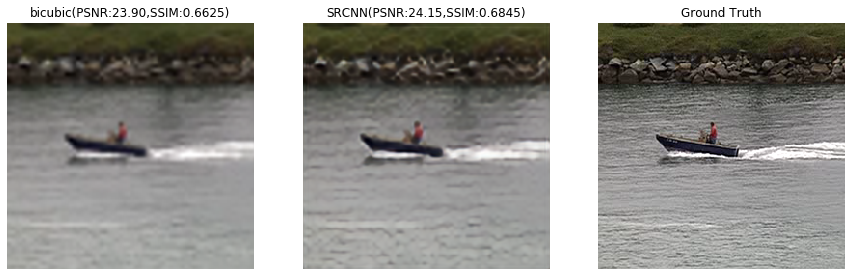

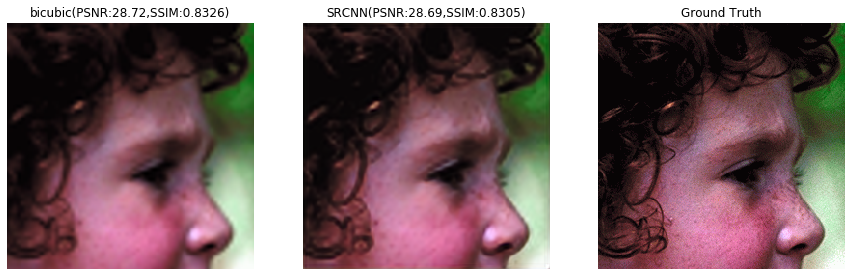

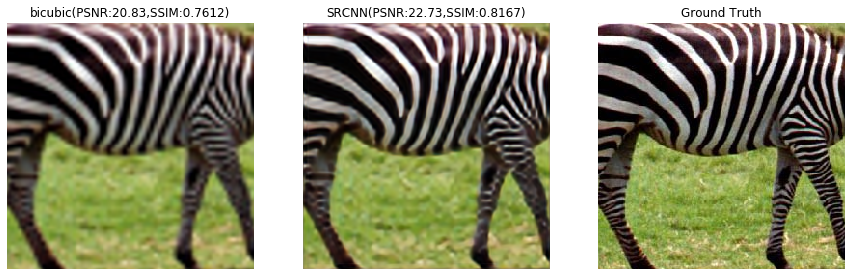

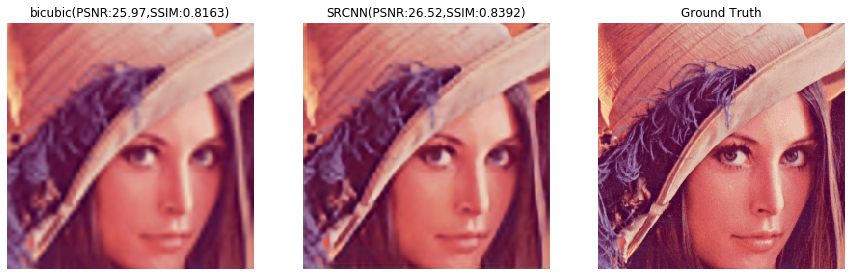

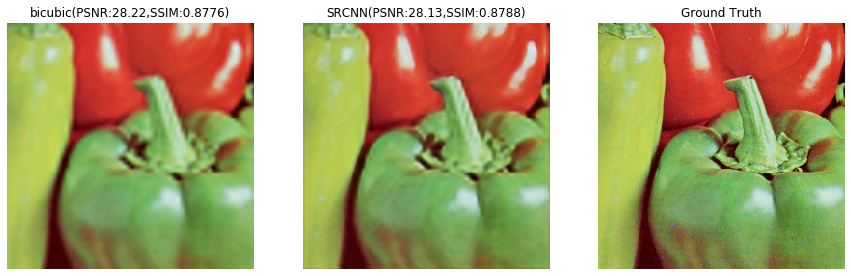

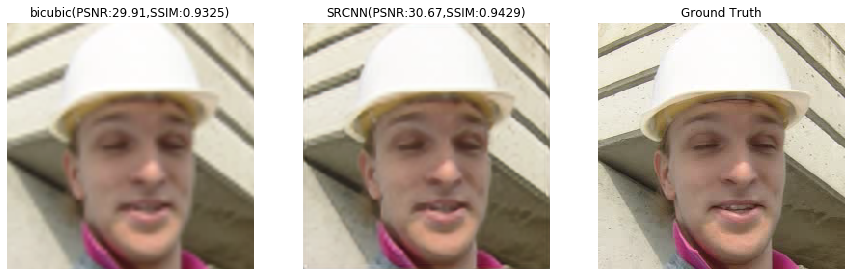

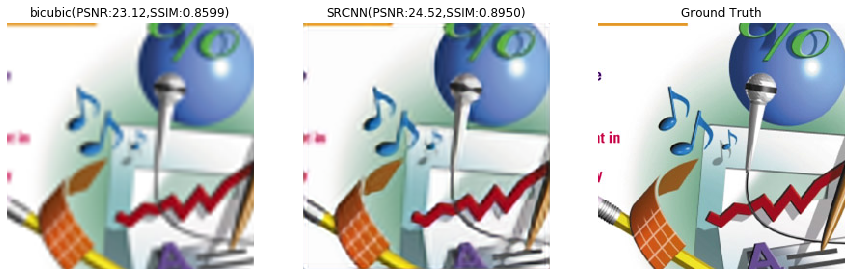

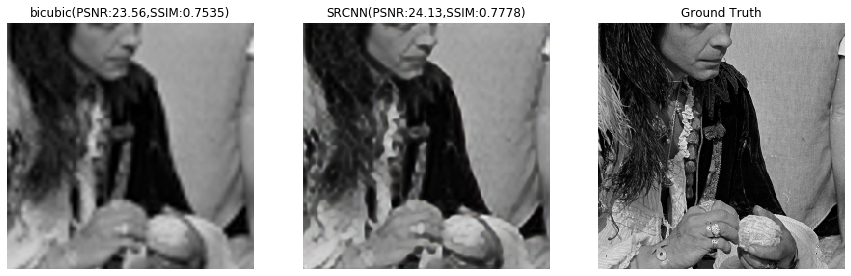

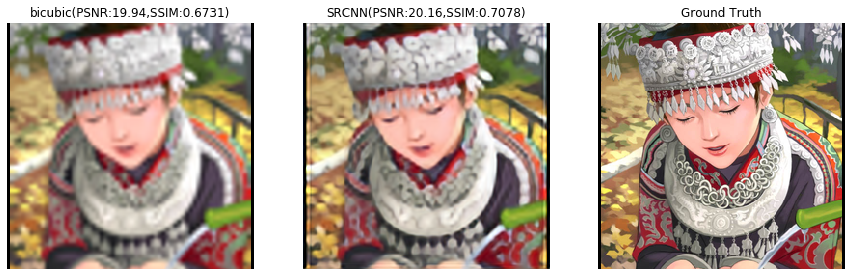

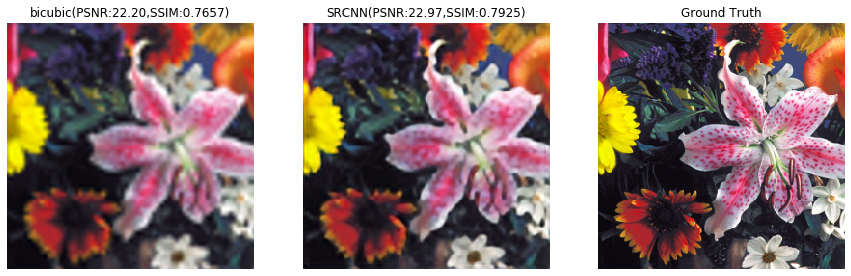

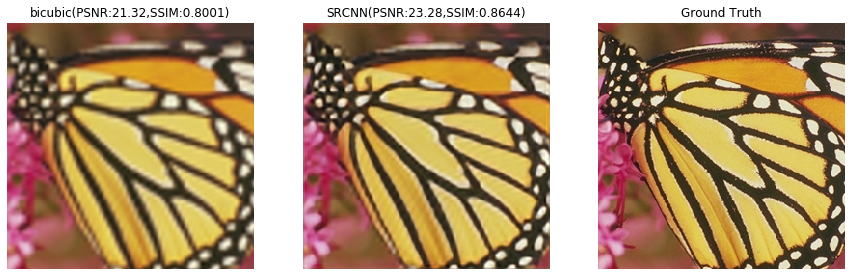

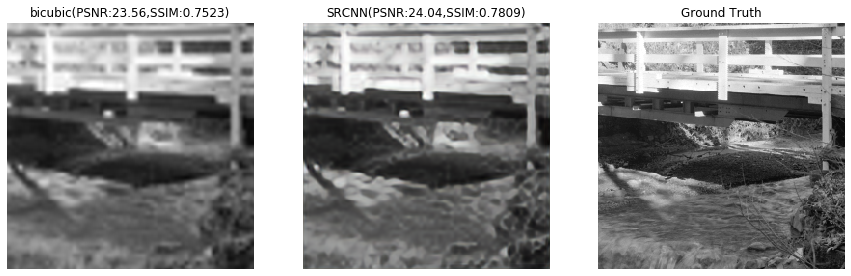

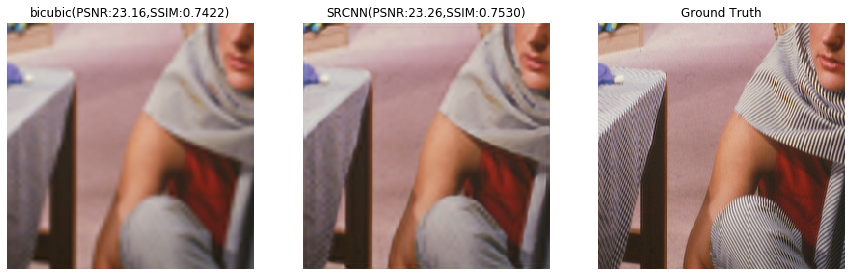

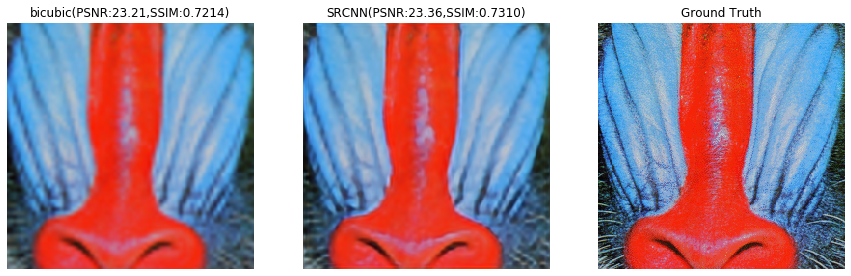

In [21]:
sr_test(learn, il_test_x, il_test_y, model_name)

## Report

In [22]:
model

SRCNN(
  (conv1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (activate): ReLU()
)

In [23]:
learn.summary()

SRCNN
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 256, 256]       15,616     True      
______________________________________________________________________
Conv2d               [32, 256, 256]       2,080      True      
______________________________________________________________________
Conv2d               [3, 256, 256]        2,403      True      
______________________________________________________________________
ReLU                 [32, 256, 256]       0          False     
______________________________________________________________________

Total params: 20,099
Total trainable params: 20,099
Total non-trainable params: 0
Optimized with 'torch.optim.adam.Adam', betas=(0.9, 0.99)
Using true weight decay as discussed in https://www.fast.ai/2018/07/02/adam-weight-decay/ 
Loss function : FlattenedLoss
Callbacks functions applied 